<a href="https://colab.research.google.com/github/RjResilient94/Analysis-and-detection-of-AI-generated-images/blob/main/fake_image_detector_combined_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install -q kaggle optuna scikit-image opencv-python-headless tqdm scikit-learn

from google.colab import files
files.upload()  # Upload kaggle.json manually

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [18]:
# CIFAKE
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images -p cifake_data --unzip


Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
cifake-real-and-ai-generated-synthetic-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import os, cv2, numpy as np
from tqdm import tqdm
from skimage.transform import radon
from scipy.stats import entropy, skew, kurtosis

from concurrent.futures import ThreadPoolExecutor

def extract_labelled_features(img_path, label):
    try:
        features = extract_features(img_path)
        return (features, label)
    except:
        return None

def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Hough
    edges = cv2.Canny(img, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=120)
    if lines is not None:
        angles = np.array([theta for rho, theta in lines[:, 0]])
        hist, _ = np.histogram(angles, bins=36, range=(0, np.pi), density=True)
        hough = [
            len(angles), np.mean(angles), np.var(angles),
            np.min(angles), np.max(angles), entropy(hist + 1e-10),
            np.sum((angles < 0.1) | (angles > np.pi - 0.1)),
            np.sum(np.abs(angles - np.pi/2) < 0.1)
        ]
    else:
        hough = [0]*8

    # Radon
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    flat = sinogram.flatten()
    radon_feats = [
        np.mean(sinogram), np.std(sinogram), skew(flat),
        kurtosis(flat), np.sum(flat**2),
        entropy(np.histogram(flat, bins=64, density=True)[0] + 1e-10),
        np.max(sinogram) / (np.mean(sinogram) + 1e-6),
        np.sum(np.diff(np.sign(np.diff(sinogram, axis=0)), axis=0) != 0),
        np.sum(np.max(sinogram, axis=0) > (np.mean(sinogram) + 2*np.std(sinogram)))
    ]
    return hough + radon_feats


In [5]:

def load_dataset_parallel(real_dir, fake_dir, max_images_per_class=None):
    X, y = [], []
    image_label_pairs = []

    real_images = sorted(os.listdir(real_dir))
    fake_images = sorted(os.listdir(fake_dir))

    if max_images_per_class is not None:
        real_images = real_images[:max_images_per_class]
        fake_images = fake_images[:max_images_per_class]

    for img_name in real_images:
        image_label_pairs.append((os.path.join(real_dir, img_name), 0))
    for img_name in fake_images:
        image_label_pairs.append((os.path.join(fake_dir, img_name), 1))

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda p: extract_labelled_features(*p), image_label_pairs),
                            total=len(image_label_pairs), desc="Parallel Feature Extraction"))

    for r in results:
        if r:
            X.append(r[0])
            y.append(r[1])

    return np.array(X), np.array(y)


# Load CIFAKE
X1, y1 = load_dataset_parallel("cifake_data/train/REAL", "cifake_data/train/FAKE", max_images_per_class=5000)

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)


Parallel Feature Extraction: 100%|██████████| 10000/10000 [10:40<00:00, 15.61it/s]


In [6]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    clf = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    return cross_val_score(clf, X_train, y_train, cv=3).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print("Best hyperparameters:", study.best_params)


[I 2025-07-09 08:36:26,519] A new study created in memory with name: no-name-12d3ef48-f513-476b-bd5c-615abfa8dfe6
[I 2025-07-09 08:36:39,440] Trial 0 finished with value: 0.6542511143346391 and parameters: {'n_estimators': 272, 'max_depth': 28, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6542511143346391.
[I 2025-07-09 08:36:47,878] Trial 1 finished with value: 0.6531261611803401 and parameters: {'n_estimators': 192, 'max_depth': 16, 'max_features': 'log2'}. Best is trial 0 with value: 0.6542511143346391.
[I 2025-07-09 08:36:51,873] Trial 2 finished with value: 0.6463759265650683 and parameters: {'n_estimators': 176, 'max_depth': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6542511143346391.
[I 2025-07-09 08:37:24,773] Trial 3 finished with value: 0.6502509579400849 and parameters: {'n_estimators': 218, 'max_depth': 26, 'max_features': None}. Best is trial 0 with value: 0.6542511143346391.
[I 2025-07-09 08:37:35,001] Trial 4 finished with value: 0.65250161434246

Best hyperparameters: {'n_estimators': 127, 'max_depth': 22, 'max_features': 'log2'}


              precision    recall  f1-score   support

           0       0.69      0.60      0.65      1012
           1       0.64      0.73      0.68       988

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.66      2000
weighted avg       0.67      0.67      0.66      2000



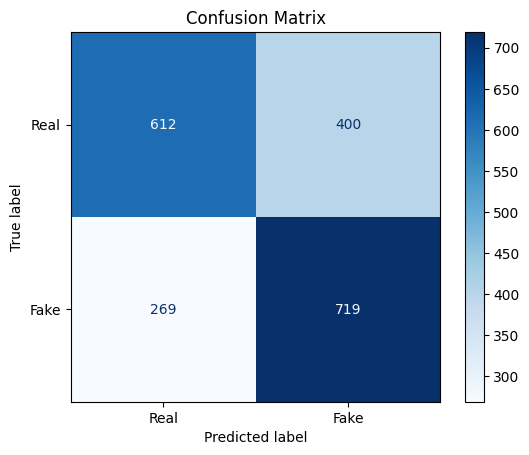

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_rf = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))
y_true = y_test
labels = sorted(set(y_true) | set(y_pred))  # Ensure all present labels included
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Saving 47064c54-ba30-483c-b60d-2c0d73d46add.jpg to 47064c54-ba30-483c-b60d-2c0d73d46add.jpg


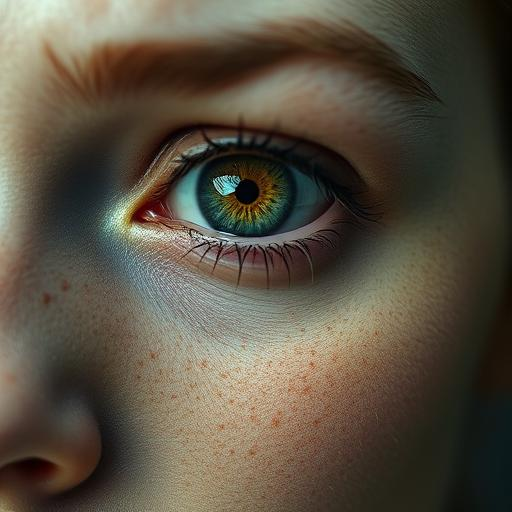

🔍 Prediction: Fake 🤖Probability : 1


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning:

Radon transform: image must be zero outside the reconstruction circle



'Fake 🤖'

In [25]:
from google.colab import files
from IPython.display import Image, display

# Upload image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
display(Image(img_path))

# Predict
def predict_single_image(img_path, model):
    features = extract_features(img_path)
    prediction = model.predict([features])[0]
    label = "Fake 🤖" if prediction == 1 else "Real 🧑"
    print(f"🔍 Prediction: {label}"+"Probability : "+str(prediction))
    return label

predict_single_image(img_path, best_rf)


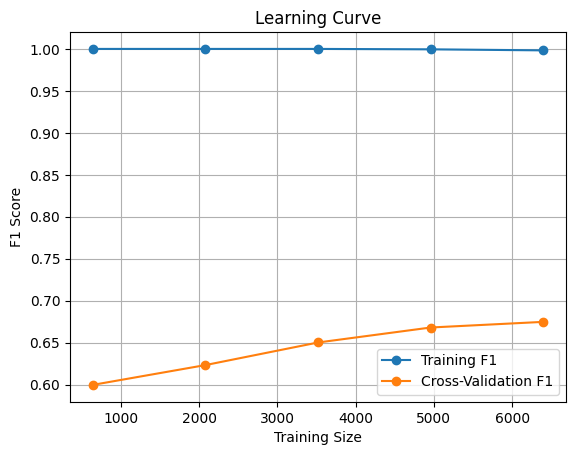

In [15]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, 'o-', label="Training F1")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-Validation F1")
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-19-2524417305.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')


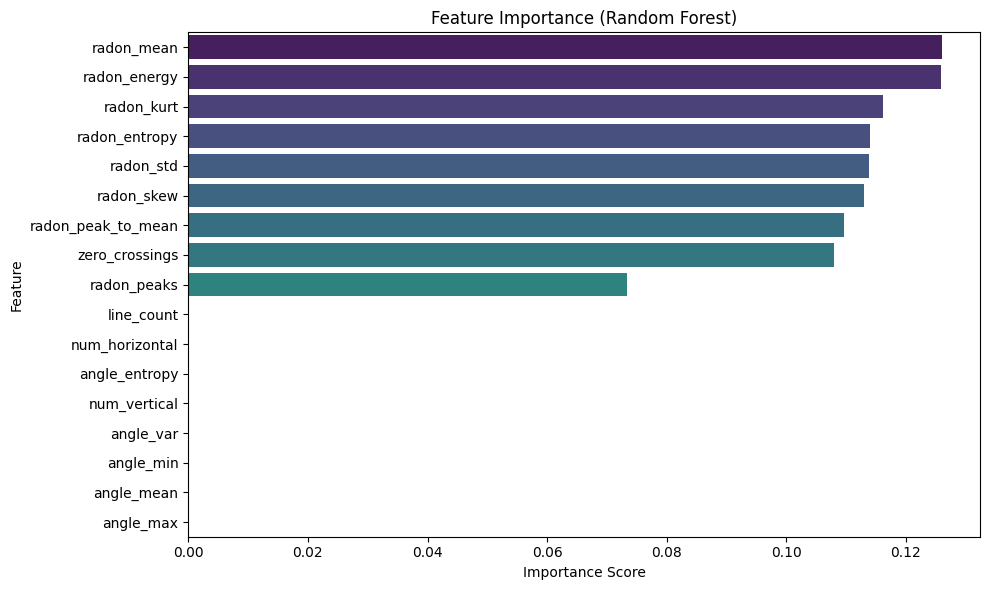

In [19]:
import pandas as pd
import seaborn as sns

feature_names = [
    'line_count', 'angle_mean', 'angle_var', 'angle_min', 'angle_max',
    'angle_entropy', 'num_vertical', 'num_horizontal',
    'radon_mean', 'radon_std', 'radon_skew', 'radon_kurt', 'radon_energy',
    'radon_entropy', 'radon_peak_to_mean', 'zero_crossings', 'radon_peaks'
]

importances = best_rf.feature_importances_
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


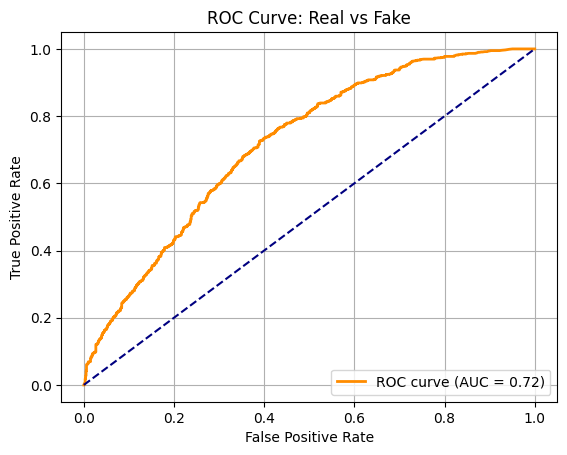

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_rf.predict_proba(X_test)[:, 1]  # Probability for class 1 (Fake)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Real vs Fake')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


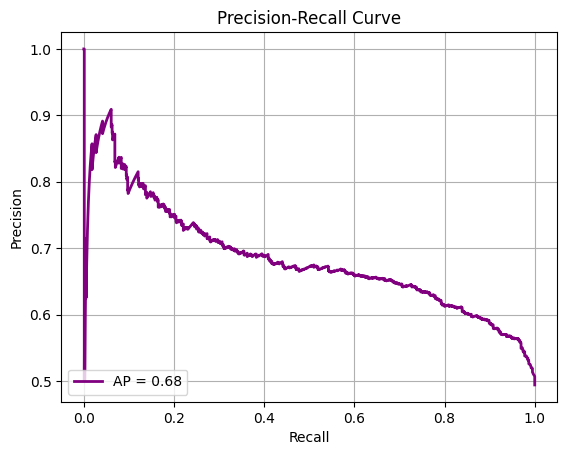

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, color='purple', lw=2, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [23]:
import optuna
from optuna.visualization import plot_optimization_history

# Create and optimize study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Plot the optimization history
fig = plot_optimization_history(study)

# Display in notebook (works in Jupyter/Colab)
fig.show()


[I 2025-07-09 09:48:03,149] A new study created in memory with name: no-name-597d4f8c-5bdf-4c37-ab18-7a3b9c53839b
[I 2025-07-09 09:48:10,733] Trial 0 finished with value: 0.6521260517604092 and parameters: {'n_estimators': 95, 'max_depth': 18, 'max_features': 'log2'}. Best is trial 0 with value: 0.6521260517604092.
[I 2025-07-09 09:48:18,343] Trial 1 finished with value: 0.6561272864147796 and parameters: {'n_estimators': 181, 'max_depth': 22, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6561272864147796.
[I 2025-07-09 09:48:27,896] Trial 2 finished with value: 0.6511261767447861 and parameters: {'n_estimators': 197, 'max_depth': 23, 'max_features': 'log2'}. Best is trial 1 with value: 0.6561272864147796.
[I 2025-07-09 09:48:35,717] Trial 3 finished with value: 0.6561256455846244 and parameters: {'n_estimators': 192, 'max_depth': 13, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6561272864147796.
[I 2025-07-09 09:48:37,784] Trial 4 finished with value: 0.649501051678